<a href="https://colab.research.google.com/github/alecbidaran/ML-for-remote-sensing-Homeworks/blob/main/Copy_of_Create_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import pandas as pd 

%matplotlib inline

In [ ]:
image_path="/content/drive/MyDrive/datasets/images"
mask_path="/content/drive/MyDrive/datasets/masks"
csv_path="/content/drive/MyDrive/datasets/drop.csv"

In [ ]:
drop_list=pd.read_csv(csv_path)
drop_list=drop_list['images_to_drop'].str.split("/").str[-1].to_list()
len(drop_list)

1520

In [ ]:
mask_names=os.listdir(mask_path)
used_masks=[mask_name for mask_name in mask_names if mask_name not in drop_list ]
len(used_masks)

244

In [ ]:
used_image_names = [os.path.join(image_path, mask_name.replace( "mask_", "T34JEP_20170101T082332_TCI_")) for mask_name in used_masks]
len(used_image_names)


244

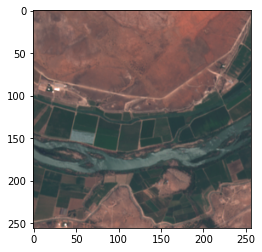

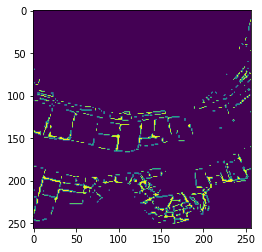

In [ ]:
img=cv2.imread(os.path.join(image_path,used_image_names[120]),cv2.IMREAD_COLOR)
mask=cv2.imread(os.path.join(mask_path,used_masks[120]),cv2.IMREAD_GRAYSCALE)
plt.imshow(img)
plt.figure()
plt.imshow(mask)

In [ ]:
def build_model(input_shape):
    inputs = Input(input_shape)

    conv1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(conv4)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(conv5)
    up5=UpSampling2D(size=(2,2))(conv5)
    up6 = Conv2D(256, (2, 2), activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(merge6)
    conv6 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(conv6)

    up7 = Conv2D(128, (2, 2), activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv6))
    up7_1=Conv2D(128, (2, 2), activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv4))
    merge7 = concatenate([conv3,up7,up7_1], axis = 3)
    conv7 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(merge7)
    conv7 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(conv7)

    up8 = Conv2D(64, (2, 2), activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv7))
    up8_1=Conv2D(64, (2, 2), activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv3))
    up8_2=Conv2D(64, (2, 2), activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(up7_1))
    merge8 = concatenate([conv2,up8,up8_1,up8_2], axis = 3)
    conv8 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(merge8)
    conv8 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(conv8)

    up9 = Conv2D(32, (2, 2), activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv8))
    up9_1=Conv2D(32, (2, 2), activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv2))
    up9_2=Conv2D(32, (2, 2), activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(up8_1))
    merge9 = concatenate([conv1,up9,up9_1,up9_2], axis = 3)
    conv9 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(merge9)
    conv9 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(conv9)
    
    outputs = Conv2D(1, (1,1), activation = 'sigmoid')(conv9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    
    return model

In [ ]:
model=build_model(input_shape=(256,256,3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("model++_ucu.hdf5", save_best_only=True, verbose=1, monitor='dice_coef', mode='max')
# read image and mask

In [ ]:
# read image and mask
def load_image(img_path):
      
    img = cv2.imread(img_path)

    return img

def load_mask(img_path):
      
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img[img>1]=1
        
    return img

In [ ]:
def generate_X(img_list):
    X = np.empty((len(img_list), 256, 256, 3))

    for i, item in enumerate(img_list):
        img = load_image(item)
        X[i,] = img

    return X

In [ ]:
#generate Y
def generate_y(mask_list):
    y = np.empty((len(mask_list), 256, 256, 1), dtype=int)

    for i, item in enumerate(mask_list):
        path=os.path.join(mask_path,item)
        mask = load_mask(path)
        y[i, :, : , 0] = mask
    
    
    return y.astype(np.float32)

In [ ]:
# loss and metrics
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return 0.2 * binary_crossentropy(y_true, y_pred) + 0.8 * dice_loss(y_true, y_pred)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X=generate_X(used_image_names)
y=generate_y(used_masks)

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [ ]:
# compile model
model.compile(optimizer=Adam(learning_rate = 1e-4),
              loss=bce_dice_loss,
              metrics=[dice_coef])

In [ ]:
history=model.fit(x_train,y_train,batch_size=8,epochs=25,validation_data=(x_test,y_test),callbacks=[early_stopping,model_checkpoint])

Epoch 1/25
25/25 [==============================] - ETA: 0s - loss: 0.6807 - dice_coef: 0.1621
Epoch 1: dice_coef improved from -inf to 0.16206, saving model to model++_ucu.hdf5
25/25 [==============================] - 11s 372ms/step - loss: 0.6807 - dice_coef: 0.1621 - val_loss: 0.6406 - val_dice_coef: 0.3107
Epoch 2/25
25/25 [==============================] - ETA: 0s - loss: 0.7200 - dice_coef: 0.1138
Epoch 2: dice_coef did not improve from 0.16206
25/25 [==============================] - 9s 348ms/step - loss: 0.7200 - dice_coef: 0.1138 - val_loss: 0.7223 - val_dice_coef: 0.2273
Epoch 3/25
25/25 [==============================] - ETA: 0s - loss: 0.6944 - dice_coef: 0.1679
Epoch 3: dice_coef improved from 0.16206 to 0.16788, saving model to model++_ucu.hdf5
25/25 [==============================] - 9s 366ms/step - loss: 0.6944 - dice_coef: 0.1679 - val_loss: 0.6973 - val_dice_coef: 0.2523
Epoch 4/25
25/25 [==============================] - ETA: 0s - loss: 0.6703 - dice_coef: 0.1964
Epo

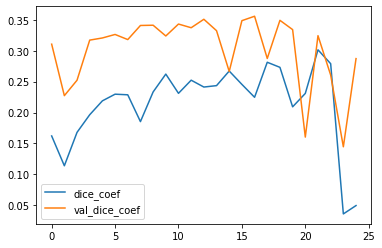

In [ ]:
plt.plot(history.history['dice_coef'],label="dice_coef")
plt.plot(history.history['val_dice_coef'],label="val_dice_coef")
plt.legend()

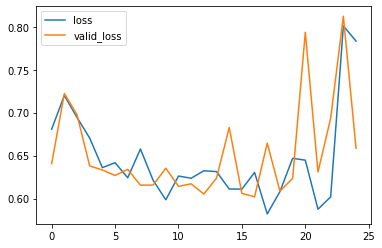

In [ ]:
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['val_loss'],label="valid_loss")
plt.legend()

In [ ]:
model=load_model("/content/model++_ucu.hdf5",custom_objects={'bce_dice_loss': bce_dice_loss,'dice_coef': dice_coef})

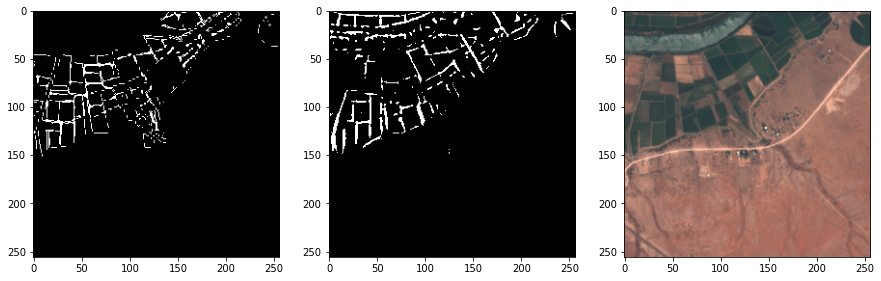

In [ ]:
z = x_test[2].reshape((1,256,256,3))

# predict 
y_pred = model.predict(z)
# binarize prediction
y_pred[y_pred < 0.5] = 0
y_pred[y_pred > 0.5] = 1

# plot the results with matplotlib
f, axarr = plt.subplots(1, 3)
f.set_size_inches(15, 15)
axarr[0].imshow(y_test[2].reshape((256,256)),cmap="gray")
axarr[1].imshow(y_pred.reshape((256,256)),cmap="gray")
axarr[2].imshow(x_test[2].astype(np.uint8))

According to above figures, the trained Unet++ was sucsessful in segmenting bigger fields while it falied to compute edges of small ones. We can address this problem that our the size our prepared dataset is little enough to train more complexed networks such as Unet++. Even we faced with overfiiting in last epochs but fortunetly we stopped it early stopping. Increasing the number of samples into 10000 to 100000 can provide us robust preformance and also could detect small fields from RGB images.